expected initial radius is  0.10437500000000001 meters
expected period is  4.372049776245796e-08 seconds
good guess for delta_t would be 1.093012444061449e-10 for 400 points
initial position 0.0 0.0 15000000.0
 initial velocity 0.0500 the speed of light
number of jumps between D's is 0
number of points is 382  * delta_t is total time =  4.1753075363147354e-08


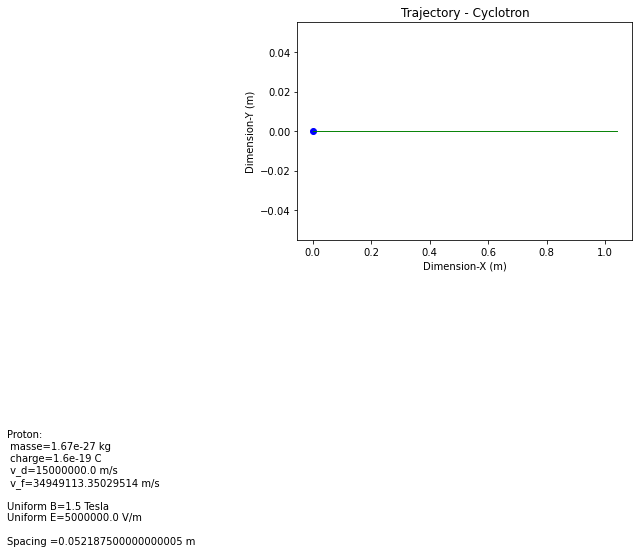

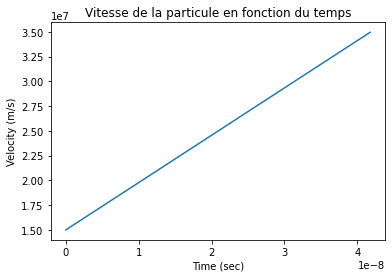

In [28]:
import math as math
import numpy as np
import matplotlib.pyplot as plt

################################################################################################
#  Force de Lorenz F = q ( E + v ^ B ) = m dv/dt
#  Dans un champ magnetique B uniforme:
#     les trajectoires sont des cercles
#     la norme de la vitesse ne change pas, seulement son orientation
#     vitesse et rayon sont lies par v/r = B q/m
#     le temps pour completer un cercle complet est 2 PI / ( B q/m )
#
#  Dans un champ Electrique E uniforme:
#     les trajectoires sont des paraboles -- droites si vitesse et E sont alignes
#     l'acceleration est constante a = E q/m
#     donc Delta v = a Delta t
################################################################################################

class Particle:
    def __init__(self, pos, vel, mass, charge):
        self.pos = pos
        self.vel = vel
        self.mass = mass
        self.charge = charge

#SPEED OF LIGHT is 299792458 m/s
speed_of_light = 3.0E08

# choose a proton as the particle
proton = Particle([0.00, 0.0, 0.0], [0.05*speed_of_light, 0.0, 0.0], 1.67E-27, +1.60E-19)

#dipole = Dipole(1.0, [100.0, 0.0, 0.0], [0.0, 0.0, 100.0])

#ELECTRIC FIELD
e_field = [5000000.0, 0.0, 0.0]
#MAGNETIC FIELD
magn_uniform_field = [0.0, 0.0, -1.5]

b = np.linalg.norm(magn_uniform_field)
v_i = np.linalg.norm(proton.vel)
expected_radius = v_i / ( b * (proton.charge/proton.mass ) )
print ('expected initial radius is ', expected_radius, 'meters')
spacing = 0.5 * expected_radius

expected_period = 2.0*math.pi/( b * (proton.charge/proton.mass ) )
print ('expected period is ', expected_period, 'seconds')
number_of_points = 400
guess_for_delta_t = expected_period / number_of_points
print ('good guess for delta_t would be', guess_for_delta_t, 'for', number_of_points,'points')

# Count how many iterations are done inside the spacing ( Electric field only )
count = 0
# Count how many times the particle jumps from 1 D to the other
jumps =0
jumps_max = 51
#  returns the acceleration due to an electromagnetic field ( from Lorenz force )
def em_acceleration( q_over_m, position, velocity ):
#     calculated for a particle at position, with velocity
#b = dipole.flux_density(position) + magn_uniform_field
#a = np.cross(velocity, b) + e_field
#a = a * q_over_m
    global count, jumps

    # Stop after limit in jumps ( E = B = 0 --> straight line
    if jumps >= jumps_max :
              a = 0
    else:
        if position[0] >= 0 or position[0] <= -spacing :
            a = np.cross(velocity, magn_uniform_field)
            a = a * q_over_m
        if count:
            print(" current velocity %1.4f the speed of light"%(np.linalg.norm(velocity) / speed_of_light) )
            count = 0
            jumps = jumps + 1
        else:
            a = np.array(e_field)
            a = a * q_over_m
        if position[1] > expected_radius:
            a = -a
            count = count + 1

    return a

#Euler method
def euler(particle, max_iter, delta_t):
    q_over_m = particle.charge / particle.mass
    results = []
    i = 0

    for i in range(max_iter):
        i += 1
        p = np.array(particle.pos)
        v = np.array(particle.vel)
        a = em_acceleration( q_over_m, p, v )
        p = p + delta_t * v
        v = v + delta_t * a
        particle.pos = p
        particle.vel = v
        #print p
        results.append(p)
    return results

#Runge-Kutta method
def rk4(particle, max_iter, delta_t):
    q_over_m = particle.charge / particle.mass

#print 'q/m is', q_over_m
#print 'delta_t is', delta_t
#print 'delta_t * q/m is', delta_t * q_over_m

    results = []

#  Initial conditions
    i = 0
    p0 = np.array(particle.pos)
    v0 = np.array(particle.vel)

    for i in range(max_iter):
        i += 1
        p1 = p0
        v1 = v0
        a1 = delta_t * em_acceleration( q_over_m, p1, v1 )
        v1 = delta_t * v1

        p2 = p0 + (v1 * 0.5)
        v2 = v0 + (a1 * 0.5)
        a2 = delta_t * em_acceleration( q_over_m, p2, v2 )
        v2 = delta_t * v2

        p3 = p0 + (v2 * 0.5)
        v3 = v0 + (a2 * 0.5)
        a3 = delta_t * em_acceleration( q_over_m, p3, v3 )
        v3 = delta_t * v3

        p4 = p0 + v3
        v4 = v0 + a3
        a4 = delta_t * em_acceleration( q_over_m, p4, v4 )
        v4 = delta_t * v4

        dv = (a1 + 2.0 * (a2 + a3) + a4)
        v0 = v0 + dv / 6.0

        dp = (v1 + 2.0 * (v2 + v3) + v4)
        p0 = p0 + dp / 6.0

        if p0[0] >= -10.0 * expected_radius and p0[0] <= 10.0 * expected_radius and \
                   p0[1] >= -10.0 * expected_radius and p0[1] <= 10.0 * expected_radius :
    #  save the velocity in z components
            p0[2] = np.linalg.norm(v0)
            results.append(p0.copy())
            p0[2] = 0.0

    return results


#MATPLOTLIB PARAMS
fig1 = plt.figure()
ax1  = fig1.add_subplot(1,1,1)

fig2 =  plt.figure()
ax2  = fig2.add_subplot(1,1,1)

#Plotting
def part_plot(particle, max_iter, method, color):

#  Mark the original position with a blue mark
    x = []
    y = []

    x.append(particle.pos[0])
    y.append(particle.pos[1])
    ax1.scatter(x, y, color = 'blue')

    z = []
    v0 = np.linalg.norm(particle.vel)
#  use z array to save the velocity
    z.append(v0)

    print ("initial position", x[0],y[0],z[0])
#print " initial velocity", v0 / speed_of_light, 'the speed of light'
    print(" initial velocity %1.4f the speed of light"%(v0 / speed_of_light) )

#q_over_m = particle.charge / particle.mass
#print 'theoretical time ( uniform B ) is', 3.1415 / ( b * q_over_m ),'seconds'

    delta_t = guess_for_delta_t
    if method == 'euler':
        results = euler(particle, max_iter, delta_t)
    elif method == 'rk4':
        results = rk4(particle, max_iter, delta_t)

#  save the positions when in the spacing in a separate array
#    so that w can change the color to red
    xc = []
    yc = []
    x = []
    y = []
    for p in results:
        z.append(p[2])
        if p[0] >= 0 or p[0] <= -spacing :
    #                  inside the D's
            if len(xc) :
                ax1.plot(xc,yc, color='red',linewidth=0.95)
                xc = []
                yc = []
            x.append(p[0])
            y.append(p[1])
        else:
    #                  inside the spacing
            if len(xc) :
                ax1.plot(x,y, color=color,linewidth=0.95)
                x = []
                y = []
            xc.append(p[0])
            yc.append(p[1])

    if len(xc) :
        ax1.plot(xc,yc, color='red',linewidth=0.95)
        xc = []
        yc = []
    if len(x) :
        ax1.plot(x,y, color=color,linewidth=0.95)
        x = []
        y = []

        print ("number of jumps between D's is", jumps)
    num_points = len(z)
    #print "final position", x[num_points-1],y[num_points-1],z[num_points-1]
    print ('number of points is', num_points, ' * delta_t is total time = ', delta_t * num_points)

    b = np.linalg.norm(magn_uniform_field)
    e = np.linalg.norm(e_field)
    v1 = z[len(z)-1]

    ax1.set_title("Trajectory - Cyclotron")
    ax1.set_xlabel("Dimension-X (m)")
    ax1.set_ylabel("Dimension-Y (m)")
    comment = "Proton:\n masse=" + str(proton.mass) + " kg\n charge=" + str(proton.charge) + " C\n v_d=" + str(v0) + " m/s"
    comment = comment + "\n v_f=" + str(v1) + " m/s"
    comment = comment + "\n\nUniform B=" + str(b) + " Tesla"
    comment = comment + "\nUniform E=" + str(e) + " V/m"
    comment = comment + "\n\nSpacing =" + str(spacing) + " m"
    ax1.text(-10.0*expected_radius, -2.*expected_radius, comment)

    t = np.linspace(0, len(z)*delta_t, len(z))
    ax2.plot(t, z )
    ax2.set_title("Vitesse de la particule en fonction du temps")
    ax2.set_xlabel("Time (sec)")
    ax2.set_ylabel("Velocity (m/s)")

part_plot(proton,100000, 'rk4', 'green')

plt.show()